In [ ]:
from collections.abc import Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


In [2]:
dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       414 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### **Задача** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

### **Задача** Выберите несколько объясняющих переменных

В качестве объясняющих переменных можно выбрать - `HP` `Attack` `Defense` `Sp. Attack` `Sp. Defense` `Speed` `Generation`

### **Задача** Разделите датасет на обучающую, валидационную и тестовую выборки

In [4]:
train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.4,
    random_state=42,
    stratify=dataframe["Legendary"],
)

validate_features, test_features, validate_target, test_target = train_test_split(
    test_features,
    test_target,
    test_size=0.5,
    random_state=42,
    stratify=test_target,
)

### Общий код и вспомогательные методы

Препроцессор для обработки данных, для всех моделей один и тот же

In [5]:
preprocessor = ColumnTransformer(
    transformers=(
        (
            "num",
            StandardScaler(),
            make_column_selector(dtype_include=["int64"]),
        ),
    ),
)

Отображение confusion matrix и отчета о качестве классификации можно выделить в функцию

In [6]:
def clf_report(
    pipeline: Pipeline | GridSearchCV,
    test_features: Iterable,
    test_target: Iterable,
    threshold: float | None = None,
) -> None:
    """Отображение confusion matrix и classification_report."""
    if threshold is None:
        test_predict = pipeline.predict(test_features)
    else:
        y_scores = pipeline.predict_proba(test_features)[:, 1]
        test_predict = (y_scores >= threshold).astype(int)

    conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
    disp = ConfusionMatrixDisplay(conf_m)
    disp.plot()
    plt.show()
    print(classification_report(test_target, test_predict))

### **Задача** Обучите модели градиентного бустинга. Сделайте предсказания целевой переменной для тестовой выборки. Постройте матрицу ошибок и рассчитайте метрики качества. Сделайте выводы относительно полученных моделей и их качества.

#### GradientBoostingClassifier

In [7]:
sklearn_gradient_boosting = Pipeline(
    [("preprocessing", preprocessor), ("classifier", GradientBoostingClassifier(random_state=42))],
)
sklearn_gradient_boosting.fit(train_features, train_target)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"(('num', ...),)"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


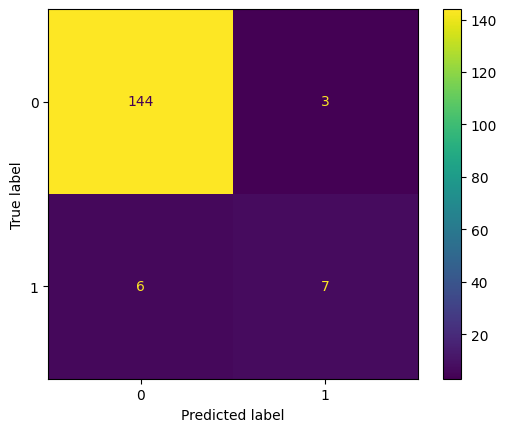

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       147
        True       0.70      0.54      0.61        13

    accuracy                           0.94       160
   macro avg       0.83      0.76      0.79       160
weighted avg       0.94      0.94      0.94       160



In [8]:
clf_report(sklearn_gradient_boosting, test_features, test_target)

In [9]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 3, 5],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__max_features": ["sqrt", "log2", None],
}
sklearn_gradient_boosting_grid = GridSearchCV(
    estimator=sklearn_gradient_boosting,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
)
sklearn_gradient_boosting_grid.fit(train_features, train_target)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__learning_rate': [0.01, 0.05, ...], 'classifier__max_depth': [3, 5, ...], 'classifier__max_features': ['sqrt', 'log2', ...], 'classifier__min_samples_leaf': [1, 3, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"(('num', ...),)"


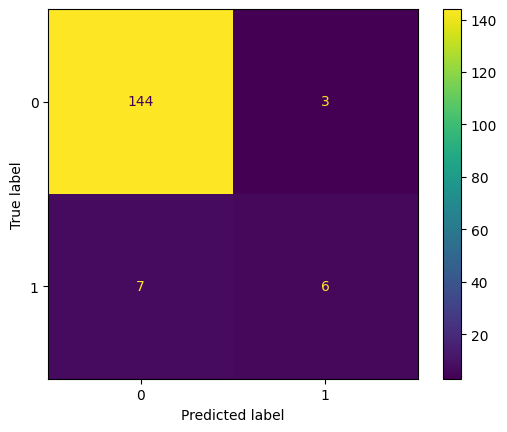

              precision    recall  f1-score   support

       False       0.95      0.98      0.97       147
        True       0.67      0.46      0.55        13

    accuracy                           0.94       160
   macro avg       0.81      0.72      0.76       160
weighted avg       0.93      0.94      0.93       160



In [10]:
clf_report(sklearn_gradient_boosting_grid, test_features, test_target)

In [11]:
results = pd.DataFrame(sklearn_gradient_boosting_grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
891,0.259417,0.070759,0.011356,0.001171,0.05,3,None,1,2,100,0.6,"{'classifier__learning_rate': 0.05, 'classifie...",0.500000,0.750000,0.666667,0.800000,0.714286,0.686190,0.102822,1
939,0.543117,0.096063,0.015162,0.002491,0.05,3,None,3,10,200,0.6,"{'classifier__learning_rate': 0.05, 'classifie...",0.545455,0.705882,0.625000,0.800000,0.714286,0.678125,0.086435,2
965,0.287555,0.105587,0.011865,0.002958,0.05,3,None,5,10,100,1.0,"{'classifier__learning_rate': 0.05, 'classifie...",0.545455,0.750000,0.625000,0.800000,0.666667,0.677424,0.090080,3
956,0.233033,0.024405,0.011470,0.001953,0.05,3,None,5,5,100,1.0,"{'classifier__learning_rate': 0.05, 'classifie...",0.545455,0.750000,0.625000,0.800000,0.666667,0.677424,0.090080,3
947,0.284361,0.053505,0.012420,0.002662,0.05,3,None,5,2,100,1.0,"{'classifier__learning_rate': 0.05, 'classifie...",0.545455,0.750000,0.625000,0.800000,0.666667,0.677424,0.090080,3
1152,0.271278,0.033880,0.010750,0.001409,0.05,5,None,1,10,100,0.6,"{'classifier__learning_rate': 0.05, 'classifie...",0.666667,0.714286,0.666667,0.714286,0.615385,0.675458,0.036820,6
1399,0.647817,0.176457,0.008218,0.001938,0.05,7,None,1,10,200,0.8,"{'classifier__learning_rate': 0.05, 'classifie...",0.615385,0.750000,0.625000,0.714286,0.666667,0.674267,0.051554,7
2125,0.322402,0.098349,0.007470,0.000415,0.10,7,None,1,10,100,0.8,"{'classifier__learning_rate': 0.1, 'classifier...",0.615385,0.800000,0.571429,0.714286,0.666667,0.673553,0.079383,8
1155,0.585469,0.093958,0.012004,0.002162,0.05,5,None,1,10,200,0.6,"{'classifier__learning_rate': 0.05, 'classifie...",0.666667,0.750000,0.571429,0.800000,0.571429,0.671905,0.092440,9
1626,0.462896,0.061960,0.007665,0.001330,0.10,3,None,1,2,300,0.6,"{'classifier__learning_rate': 0.1, 'classifier...",0.615385,0.705882,0.571429,0.800000,0.666667,0.671872,0.078588,10


Судя по `std_test_score` модель весьма нестабильна, возможно данных слишком мало.

В целом метрики получились не очень хорошими и удовлетворительных результатов не удалось получить перебором параметров. Почти половина легендарных покемонов не была определена.

#### LightGBM

[LightGBM] [Info] Number of positive: 39, number of negative: 441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081250 -> initscore=-2.425483
[LightGBM] [Info] Start training from score -2.425483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


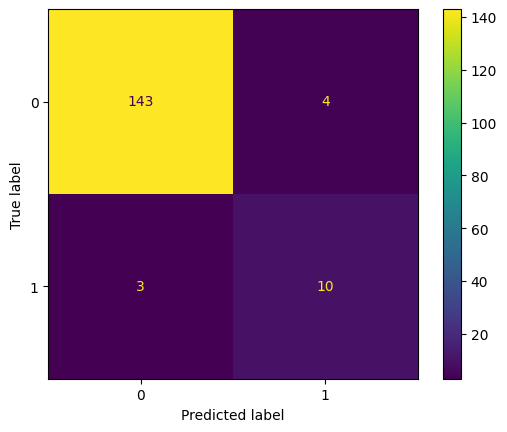

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160



In [12]:
light_gbm_boosting = Pipeline(
    [("preprocessing", preprocessor), ("classifier", LGBMClassifier(random_state=42, is_unbalance=True, n_jobs=-1))],
)
light_gbm_boosting.fit(train_features, train_target)
clf_report(light_gbm_boosting, test_features, test_target)

In [13]:
param_grid = {
    "classifier__verbose": [-1],
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__num_leaves": [7, 15, 31],
    "classifier__max_depth": [3, 5, 7],
    "classifier__min_child_samples": [5, 10, 20],
}
light_gbm_boosting_grid = GridSearchCV(
    estimator=light_gbm_boosting,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
)
light_gbm_boosting_grid.fit(train_features, train_target)

/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklea

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__learning_rate': [0.01, 0.05, ...], 'classifier__max_depth': [3, 5, ...], 'classifier__min_child_samples': [5, 10, ...], 'classifier__n_estimators': [50, 100, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"(('num', ...),)"


/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


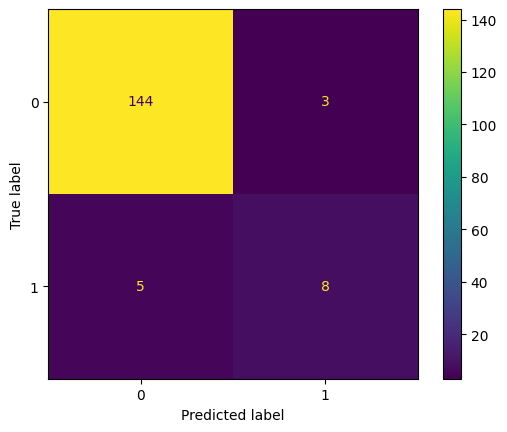

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [14]:
clf_report(light_gbm_boosting_grid, test_features, test_target)

In [15]:
results = pd.DataFrame(light_gbm_boosting_grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_samples,param_classifier__n_estimators,param_classifier__num_leaves,param_classifier__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
160,3.288356,0.093714,0.009400,0.001901,0.05,7,20,200,15,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.666667,0.666667,0.625000,0.75,0.800000,0.701667,0.063770,1
161,3.575161,0.114538,0.008291,0.002348,0.05,7,20,200,31,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.666667,0.666667,0.625000,0.75,0.800000,0.701667,0.063770,1
61,3.500752,0.096919,0.009828,0.001779,0.01,7,5,200,15,-1,"{'classifier__learning_rate': 0.01, 'classifie...",0.545455,0.666667,0.800000,0.75,0.714286,0.695281,0.086704,3
114,1.879201,0.031416,0.008319,0.002515,0.05,5,5,200,7,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.545455,0.705882,0.705882,0.80,0.714286,0.694301,0.082456,4
106,1.390599,0.032175,0.011588,0.002470,0.05,3,20,200,15,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.533333,0.666667,0.736842,0.80,0.714286,0.690226,0.089412,5
107,1.382029,0.043308,0.011102,0.002563,0.05,3,20,200,31,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.533333,0.666667,0.736842,0.80,0.714286,0.690226,0.089412,5
70,3.457784,0.137221,0.009731,0.003355,0.01,7,10,200,15,-1,"{'classifier__learning_rate': 0.01, 'classifie...",0.666667,0.625000,0.714286,0.75,0.666667,0.684524,0.043252,7
71,5.294493,0.960877,0.010239,0.002812,0.01,7,10,200,31,-1,"{'classifier__learning_rate': 0.01, 'classifie...",0.666667,0.625000,0.714286,0.75,0.666667,0.684524,0.043252,7
130,1.371178,0.077065,0.008607,0.002364,0.05,5,20,100,15,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.615385,0.666667,0.588235,0.75,0.800000,0.684057,0.079989,9
131,1.412314,0.096857,0.012408,0.003502,0.05,5,20,100,31,-1,"{'classifier__learning_rate': 0.05, 'classifie...",0.615385,0.666667,0.588235,0.75,0.800000,0.684057,0.079989,9


На тестовых данных модель показывает результаты лучше при параметрах по умолчанию.

Если задать параметр `is_unbalance=True` модель показывает сразу же хорошие сбалансированные результаты - хорошую точность и полноту. 77% покемонов было определено на тестовых данных (recall - 0.77) при этом всего 29% - ложное срабатывание (precision - 0.71).

#### XGBoost

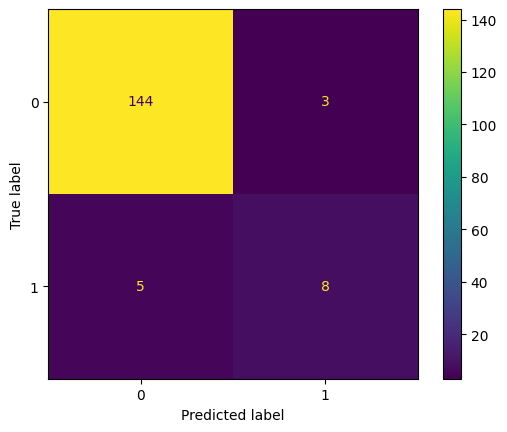

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [16]:
xg_boosting = Pipeline(
    [("preprocessing", preprocessor), ("classifier", XGBClassifier(random_state=42, n_jobs=-1))],
)
xg_boosting.fit(train_features, train_target)
clf_report(xg_boosting, test_features, test_target)

In [17]:
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__min_child_weight": [1, 3, 5],
    "classifier__gamma": [0, 0.1, 0.3],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__scale_pos_weight": [1, 5, 10, 20],
}
xg_boosting_grid = GridSearchCV(
    estimator=xg_boosting,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
)
xg_boosting_grid.fit(train_features, train_target)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'classifier__colsample_bytree': [0.6, 0.8, ...], 'classifier__gamma': [0, 0.1, ...], 'classifier__learning_rate': [0.01, 0.05, ...], 'classifier__max_depth': [3, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"(('num', ...),)"


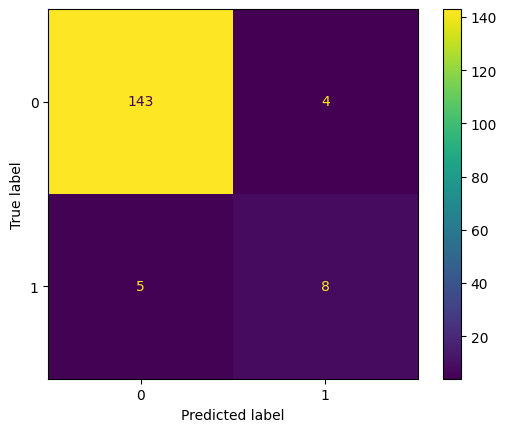

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       147
        True       0.67      0.62      0.64        13

    accuracy                           0.94       160
   macro avg       0.82      0.79      0.80       160
weighted avg       0.94      0.94      0.94       160



In [18]:
clf_report(xg_boosting_grid, test_features, test_target)

In [19]:
results = pd.DataFrame(xg_boosting_grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,...,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5084,0.030141,0.002790,0.009571,0.000827,0.8,0.3,0.01,7,1,50,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.777778,0.777778,0.769231,0.707382,0.091230,1
3140,0.027636,0.001226,0.009044,0.000652,0.8,0.0,0.01,7,1,50,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.777778,0.777778,0.769231,0.707382,0.091230,1
4112,0.032698,0.001145,0.010871,0.001227,0.8,0.1,0.01,7,1,50,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.777778,0.777778,0.769231,0.707382,0.091230,1
5105,0.115249,0.010303,0.020443,0.014134,0.8,0.3,0.01,7,1,200,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
4133,0.080710,0.009831,0.010822,0.001807,0.8,0.1,0.01,7,1,200,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
4433,0.026451,0.001254,0.008555,0.000351,0.8,0.1,0.05,7,1,50,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
3053,0.062687,0.003810,0.009114,0.000623,0.8,0.0,0.01,5,1,200,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
4997,0.145887,0.064938,0.018145,0.004324,0.8,0.3,0.01,5,1,200,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
3161,0.103311,0.029229,0.014447,0.004876,0.8,0.0,0.01,7,1,200,...,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.545455,0.666667,0.750000,0.800000,0.769231,0.706270,0.091752,4
3681,0.022128,0.000930,0.008646,0.000577,0.8,0.0,0.10,5,1,50,...,0.6,"{'classifier__colsample_bytree': 0.8, 'classif...",0.500000,0.666667,0.700000,0.888889,0.750000,0.701111,0.125924,10


На тестовых данных модель показывает результаты лучше при параметрах по умолчанию. Высокий `std_test_score` может говорить о некоторой нестабильности модели, возможно это из-за небольшого количеств данных.

На тестовых данных метрики получились приемлемыми, удалось выявить 62% легендарных покемонов (recall 0.62), при этом 27% ложных срабатываний (precision - 0.73).

#### CatBoost

Learning rate set to 0.007531
0:	learn: 0.6855198	total: 46.7ms	remaining: 46.6s
1:	learn: 0.6785752	total: 47.4ms	remaining: 23.6s
2:	learn: 0.6686656	total: 47.8ms	remaining: 15.9s
3:	learn: 0.6596197	total: 48.2ms	remaining: 12s
4:	learn: 0.6488585	total: 48.6ms	remaining: 9.68s
5:	learn: 0.6387911	total: 49.3ms	remaining: 8.16s
6:	learn: 0.6313760	total: 50.1ms	remaining: 7.1s
7:	learn: 0.6234023	total: 50.7ms	remaining: 6.29s
8:	learn: 0.6143547	total: 51.3ms	remaining: 5.65s
9:	learn: 0.6069905	total: 51.8ms	remaining: 5.13s
10:	learn: 0.6012239	total: 52.3ms	remaining: 4.7s
11:	learn: 0.5935511	total: 52.8ms	remaining: 4.35s
12:	learn: 0.5866075	total: 53.3ms	remaining: 4.05s
13:	learn: 0.5783996	total: 53.7ms	remaining: 3.78s
14:	learn: 0.5705060	total: 54.1ms	remaining: 3.55s
15:	learn: 0.5632582	total: 54.5ms	remaining: 3.35s
16:	learn: 0.5548643	total: 55ms	remaining: 3.18s
17:	learn: 0.5495693	total: 55.4ms	remaining: 3.02s
18:	learn: 0.5426442	total: 55.8ms	remaining: 2.88

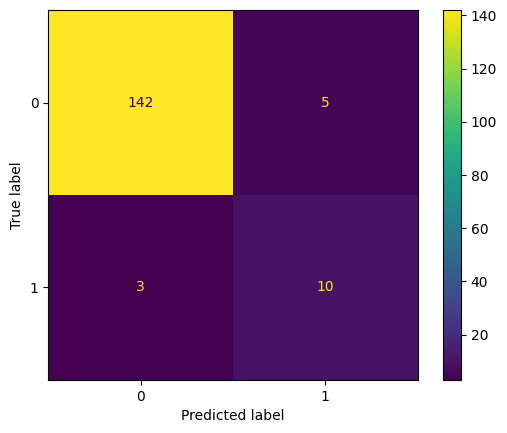

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       147
        True       0.67      0.77      0.71        13

    accuracy                           0.95       160
   macro avg       0.82      0.87      0.84       160
weighted avg       0.95      0.95      0.95       160



In [20]:
cat_boosting = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("classifier", CatBoostClassifier(random_state=42, allow_writing_files=False, auto_class_weights="Balanced")),
    ],
)
cat_boosting.fit(train_features, train_target)
clf_report(cat_boosting, test_features, test_target)

In [21]:
param_grid = {
    "classifier__iterations": [100, 300],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__depth": [3, 4, 5, 6],
    "classifier__l2_leaf_reg": [1, 3, 5, 7, 9],
    "classifier__border_count": [32, 64, 128],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__rsm": [0.8, 1.0],
    "classifier__silent": [True],
}
cat_boost_grid = GridSearchCV(
    estimator=cat_boosting,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
)
cat_boost_grid.fit(train_features, train_target)

,estimator,Pipeline(step...b7d039d410>)])
,param_grid,"{'classifier__border_count': [32, 64, ...], 'classifier__depth': [3, 4, ...], 'classifier__iterations': [100, 300], 'classifier__l2_leaf_reg': [1, 3, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"(('num', ...),)"


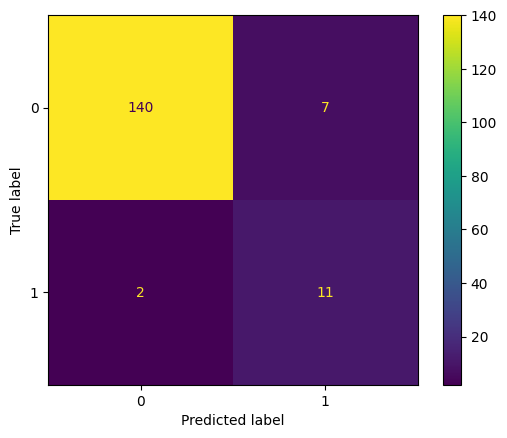

              precision    recall  f1-score   support

       False       0.99      0.95      0.97       147
        True       0.61      0.85      0.71        13

    accuracy                           0.94       160
   macro avg       0.80      0.90      0.84       160
weighted avg       0.96      0.94      0.95       160



In [22]:
clf_report(cat_boost_grid, test_features, test_target)

In [23]:
results = pd.DataFrame(cat_boost_grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__border_count,param_classifier__depth,param_classifier__iterations,param_classifier__l2_leaf_reg,param_classifier__learning_rate,param_classifier__rsm,...,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
590,0.160336,0.084280,0.014988,0.013359,32,6,100,5,0.10,0.8,...,1.0,"{'classifier__border_count': 32, 'classifier__...",0.526316,0.777778,0.700000,0.941176,0.666667,0.722387,0.136372,1
192,0.110405,0.060186,0.022156,0.017107,32,4,100,1,0.10,0.8,...,0.6,"{'classifier__border_count': 32, 'classifier__...",0.461538,0.777778,0.700000,0.941176,0.705882,0.717275,0.154675,2
1326,0.326386,0.204576,0.022676,0.015946,64,6,100,7,0.10,0.8,...,0.6,"{'classifier__border_count': 64, 'classifier__...",0.555556,0.736842,0.736842,0.888889,0.666667,0.716959,0.108564,3
572,0.151391,0.036328,0.018313,0.015032,32,6,100,3,0.10,0.8,...,1.0,"{'classifier__border_count': 32, 'classifier__...",0.500000,0.736842,0.736842,0.941176,0.666667,0.716305,0.141889,4
652,0.798463,0.417229,0.018987,0.012149,32,6,300,3,0.01,1.0,...,0.8,"{'classifier__border_count': 32, 'classifier__...",0.533333,0.705882,0.736842,0.888889,0.705882,0.714166,0.113031,5
589,0.147259,0.080929,0.028490,0.028783,32,6,100,5,0.10,0.8,...,0.8,"{'classifier__border_count': 32, 'classifier__...",0.588235,0.736842,0.666667,0.941176,0.631579,0.712900,0.124077,6
591,0.118823,0.093671,0.010149,0.003217,32,6,100,5,0.10,1.0,...,0.6,"{'classifier__border_count': 32, 'classifier__...",0.588235,0.666667,0.700000,0.941176,0.666667,0.712549,0.120077,7
632,0.934513,0.538335,0.016868,0.018487,32,6,300,1,0.01,0.8,...,1.0,"{'classifier__border_count': 32, 'classifier__...",0.461538,0.705882,0.736842,0.941176,0.705882,0.710264,0.152269,8
1170,0.741189,0.514323,0.023391,0.020527,64,5,300,1,0.01,0.8,...,0.6,"{'classifier__border_count': 64, 'classifier__...",0.461538,0.705882,0.736842,0.941176,0.705882,0.710264,0.152269,8
631,0.733676,0.749050,0.021300,0.027011,32,6,300,1,0.01,0.8,...,0.8,"{'classifier__border_count': 32, 'classifier__...",0.500000,0.666667,0.736842,0.941176,0.705882,0.710114,0.141533,10


Удалось поднять recall на тестовых данных. Судя по `std_test_score` модель нестабильна, скорее всего из-за небольшого количества данных и сильного дисбаланса классов.

Алгоритм показал себя очень хорошо, на тестовых данных отличные метрики как с параметрами по умолчанию так и после подбора параметров. На тестовых данных удалось выявить 85% легендарных покемонов, при этом ложных срабатываний 39%.

Чтобы поднять полноту можно построить `precision-recall curve` и попробовать подобрать границу классификации исходя из графика. 

<Axes: title={'center': 'Tuned Model (GridSearchCV)'}, xlabel='Threshold', ylabel='Precision'>

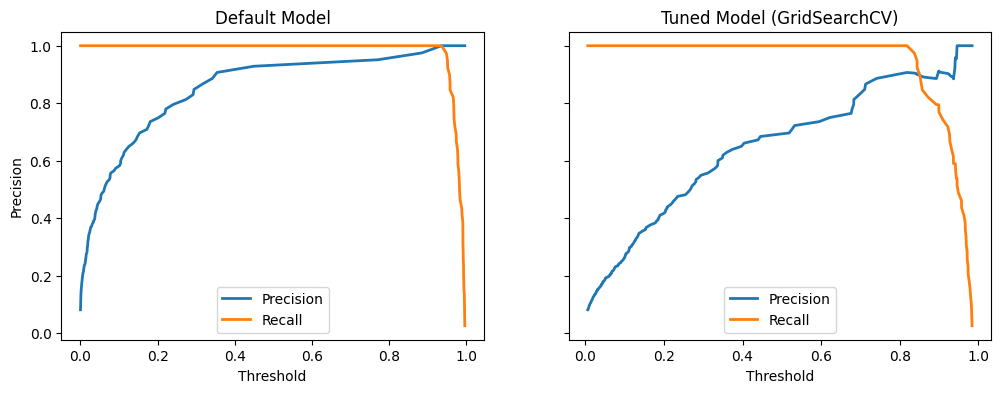

In [24]:
def get_pr_df(model: Pipeline | GridSearchCV, X_val, y_val) -> pd.DataFrame:
    """Получить dataframe с Threshold, Precision, Recall из precision_recall_curve ."""
    y_scores = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
    return pd.DataFrame({"Threshold": thresholds, "Precision": precision[:-1], "Recall": recall[:-1]})


cat_boosting_results = get_pr_df(cat_boosting, train_features, train_target)
cat_boosting_grid_results = get_pr_df(cat_boost_grid, train_features, train_target)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].set_title("Default Model")
axes[1].set_title("Tuned Model (GridSearchCV)")
sns.lineplot(data=cat_boosting_results, x="Threshold", y="Precision", ax=axes[0], label="Precision", linewidth=2)
sns.lineplot(data=cat_boosting_results, x="Threshold", y="Recall", ax=axes[0], label="Recall", linewidth=2)
sns.lineplot(data=cat_boosting_grid_results, x="Threshold", y="Precision", ax=axes[1], label="Precision", linewidth=2)
sns.lineplot(data=cat_boosting_grid_results, x="Threshold", y="Recall", ax=axes[1], label="Recall", linewidth=2)

Исходя из графика выше, вместо медленного перебора параметров в GridSearchCV можно пожертвовать точностью и выбрать threshold 0.3

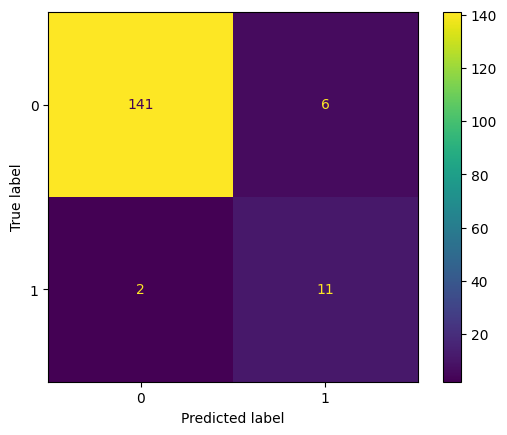

              precision    recall  f1-score   support

       False       0.99      0.96      0.97       147
        True       0.65      0.85      0.73        13

    accuracy                           0.95       160
   macro avg       0.82      0.90      0.85       160
weighted avg       0.96      0.95      0.95       160



In [25]:
clf_report(cat_boosting, test_features, test_target, 0.3)

На тестовых данных путем снижения threshold (увеличение чувствительности) удалось получить метрики не хуже чем после перебора параметров в GridSearchCV.

### **Задача** Сравните качество ансамблей с качеством одиночных классификаторов

Алгоритмы градиентного бустинга очень удобны и сразу дают хорошие результаты, но возможно несколько сложны при подборе гиперпараметров, у каждого из алгоритмов обширная документация с описанием работы. Также не у каждой одиночной модели есть возможность посмотреть на важность объясняющих переменных.

Исходя из прошлой работы над ансамблями при обучении одиночных моделей были получены следующие метрики:
|Модель   |precision|recall|f1-score|
|---------|:-------:|:----:|:------:|
|Logistic |0.58     |0.85  |0.69    |
|KNN      |0.88     |0.54  |0.67    |
|SVC      |0.67     |0.92  |0.77    |

Схожие метрики получились при обучении одиночной модели основанной на алгоритме SVM. Логистическая регрессия и KNN получились менее сбалансированными.